In [25]:
import math
import warnings
from dataclasses import dataclass

import numpy as np
import pandas as pd

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [26]:
# =========================
# 0) Target config
# =========================
TARGETS_FLOW = ["Q_in"]
TARGETS_TMS  = ["TOC_VU", "PH_VU", "SS_VU", "FLUX_VU", "TN_VU", "TP_VU"]
TARGETS_ALL  = TARGETS_FLOW + TARGETS_TMS

def get_target_cols(mode):
    mode = mode.lower().strip()
    if mode == "flow":
        return TARGETS_FLOW
    if mode == "tms":
        return TARGETS_TMS
    if mode == "all":
        return TARGETS_ALL
    raise ValueError("mode must be one of: 'flow', 'tms', 'all'")


In [27]:
# =========================
# 1) Time index & merge
# =========================
def set_datetime_index(df, time_col, tz= None):
    out = df.copy()
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
    out = out.dropna(subset=[time_col]).set_index(time_col).sort_index()
    return out

In [28]:
def summarize_available_period(dfs):
    rows = []
    for name, df in dfs.items():
        if df is None or len(df) == 0:
            rows.append([name, None, None, 0])
        else:
            rows.append([name, df.index.min(), df.index.max(), len(df)])
    return pd.DataFrame(rows, columns=["source", "start", "end", "n_rows"])


In [29]:
def merge_sources_on_time(dfs, how = "outer"):
    items = [df.copy() for df in dfs.values() if df is not None and len(df) > 0]
    if not items:
        raise ValueError("No non-empty dataframes to merge.")
    out = items[0]
    for nxt in items[1:]:
        out = out.join(nxt, how=how)
    out = out.sort_index()
    return out

In [30]:
# =========================
# 2) Cleaning & resample
# =========================
def drop_missing_rows(df, cols = None):
    out = df.copy()
    if cols is None:
        return out.dropna()
    return out.dropna(subset=cols)

In [31]:
def resample_hourly(df, rule = "1h", agg = "mean"):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df must have a DatetimeIndex for resampling.")
    out = df.copy()
    if isinstance(agg, str):
        return out.resample(rule).agg(agg)
    return out.resample(rule).agg(agg)

In [32]:
def check_continuity(df, freq = "1h"):
    if len(df) == 0:
        return {"is_continuous": True, "n_missing_timestamps": 0, "max_gap": pd.Timedelta(0)}

    idx = df.index
    expected = pd.date_range(start=idx.min(), end=idx.max(), freq=freq, tz=idx.tz)
    missing = expected.difference(idx)
    # max gap based on diff
    diffs = idx.to_series().diff().dropna()
    max_gap = diffs.max() if len(diffs) else pd.Timedelta(0)
    return {
        "is_continuous": len(missing) == 0,
        "n_missing_timestamps": len(missing),
        "max_gap": max_gap
    }

In [33]:
# =========================
# 3) Feature Engineering
# =========================
def add_time_features(df, add_sin_cos = True):
    out = df.copy()
    idx = out.index
    if not isinstance(idx, pd.DatetimeIndex):
        raise ValueError("df must have a DatetimeIndex for time features.")

    out["hour"] = idx.hour
    out["dayofweek"] = idx.dayofweek  # Mon=0
    out["month"] = idx.month
    out["is_weekend"] = (idx.dayofweek >= 5).astype(int)

    # time-of-day bucket (customize if you want)
    # 0: night(0-5), 1: morning(6-11), 2: afternoon(12-17), 3: evening(18-23)
    out["tod_bucket"] = pd.cut(
        out["hour"],
        bins=[-1, 5, 11, 17, 23],
        labels=[0, 1, 2, 3]
    ).astype(int)

    # season
    m = out["month"]
    season_map = {12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}
    out["season"] = m.map(season_map).astype(int)

    if add_sin_cos:
        # hour cycle (24)
        out["sin_hour"] = np.sin(2 * np.pi * out["hour"] / 24.0)
        out["cos_hour"] = np.cos(2 * np.pi * out["hour"] / 24.0)

        # dayofweek cycle (7)
        out["sin_dow"] = np.sin(2 * np.pi * out["dayofweek"] / 7.0)
        out["cos_dow"] = np.cos(2 * np.pi * out["dayofweek"] / 7.0)

        # month cycle (12)
        out["sin_month"] = np.sin(2 * np.pi * out["month"] / 12.0)
        out["cos_month"] = np.cos(2 * np.pi * out["month"] / 12.0)

    return out


In [34]:
def add_lag_features(df, base_cols, lags):

    out = df.copy()
    for c in base_cols:
        if c not in out.columns:
            continue
        for k in lags:
            out[f"{c}_lag{k}"] = out[c].shift(k)
    return out

In [35]:
def add_rolling_features(df, base_cols, windows, stats = ["mean"]):
    """
    stats: ["mean", "std", "min", "max"]
    """
    out = df.copy()
    for c in base_cols:
        if c not in out.columns:
            continue
        for w in windows:
            r = out[c].rolling(window=w, min_periods=w)
            if "mean" in stats:
                out[f"{c}_r{w}_mean"] = r.mean()
            if "std" in stats:
                out[f"{c}_r{w}_std"] = r.std()
            if "min" in stats:
                out[f"{c}_r{w}_min"] = r.min()
            if "max" in stats:
                out[f"{c}_r{w}_max"] = r.max()
    return out


In [36]:
def make_supervised_dataset(df, target_cols, dropna = True):
    missing = [c for c in target_cols if c not in df.columns]
    if missing:
        raise ValueError(f"target_cols not found in df: {missing}")

    y = df[target_cols].copy()
    X = df.drop(columns=target_cols).copy()

    X = X.select_dtypes(include=[np.number])

    keep = X.notna().all(axis=1) & y.notna().all(axis=1)
    return X.loc[keep], y.loc[keep]

In [37]:
@dataclass
class FeatureConfig:
    add_time = True
    add_sin_cos = True
    lag_hours = None
    roll_hours = None

    def __post_init__(self):
        if self.lag_hours is None:
            self.lag_hours = [1, 2, 3, 6, 12, 24]
        if self.roll_hours is None:
            self.roll_hours = [1, 2, 24]

In [38]:
def build_features(df_hourly, target_cols, feature_base_cols = None, cfg = FeatureConfig()):
    out = df_hourly.copy()

    if cfg.add_time:
        out = add_time_features(out, add_sin_cos=cfg.add_sin_cos)

    if feature_base_cols is None:
        numeric_cols = out.select_dtypes(include=[np.number]).columns.tolist()
        feature_base_cols = [c for c in numeric_cols if c not in target_cols]

    out = add_lag_features(out, base_cols=feature_base_cols, lags=cfg.lag_hours)
    out = add_rolling_features(out, base_cols=feature_base_cols, windows=cfg.roll_hours)
    return out

In [39]:
# =========================
# 4) Split (time-based)
# =========================
@dataclass
class SplitConfig:
    train_ratio = 0.6
    valid_ratio = 0.2
    test_ratio = 0.2


In [40]:
def time_split(X, y, cfg = SplitConfig()):
    n = len(X)
    if n == 0:
        raise ValueError("Empty dataset after preprocessing/feature generation.")
    if not math.isclose(cfg.train_ratio + cfg.valid_ratio + cfg.test_ratio, 1.0, rel_tol=1e-6):
        raise ValueError("train/valid/test ratios must sum to 1.0")

    n_train = int(n * cfg.train_ratio)
    n_valid = int(n * cfg.valid_ratio)

    X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
    X_valid, y_valid = X.iloc[n_train:n_train+n_valid], y.iloc[n_train:n_train+n_valid]
    X_test,  y_test  = X.iloc[n_train+n_valid:], y.iloc[n_train+n_valid:]

    return {
        "train": (X_train, y_train),
        "valid": (X_valid, y_valid),
        "test":  (X_test,  y_test),
    }

In [41]:
# =========================
# 5) Models
# =========================
def build_model_zoo(random_state = 42):

    zoo = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0, random_state=random_state),
        "Lasso": Lasso(alpha=0.001, random_state=random_state, max_iter=5000),
        "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=random_state, max_iter=5000),
        "RandomForest": RandomForestRegressor(
            n_estimators=300, random_state=random_state, n_jobs=-1
        ),
        "HistGBR": HistGradientBoostingRegressor(
            random_state=random_state, learning_rate=0.05, max_iter=500
        ),
    }
    return zoo

In [42]:
def wrap_multioutput_if_needed(model, y):

    if y.shape[1] <= 1:
        return model

    # HistGBR needs wrapper
    if isinstance(model, HistGradientBoostingRegressor):
        return MultiOutputRegressor(model)
    return model

In [43]:
# =========================
# 6) Metrics & Evaluation
# =========================
def compute_metrics(y_true, y_pred):
    # Ensure 2D
    yt = np.asarray(y_true)
    yp = np.asarray(y_pred)
    if yt.ndim == 1:
        yt = yt.reshape(-1, 1)
    if yp.ndim == 1:
        yp = yp.reshape(-1, 1)

    r2s, rmses, mapes = [], [], []
    for j in range(yt.shape[1]):
        r2s.append(r2_score(yt[:, j], yp[:, j]))
        rmses.append(math.sqrt(mean_squared_error(yt[:, j], yp[:, j])))
        mapes.append(mean_absolute_percentage_error(yt[:, j], yp[:, j]) * 100.0)

    return {
        "R2_mean": float(np.mean(r2s)),
        "RMSE_mean": float(np.mean(rmses)),
        "MAPE_mean(%)": float(np.mean(mapes)),
        "R2_by_target": r2s,
        "RMSE_by_target": rmses,
        "MAPE_by_target(%)": mapes,
    }

In [44]:
def fit_and_evaluate(model, splits):

    X_train, y_train = splits["train"]

    model.fit(X_train, y_train)

    out = {}
    for name, (X_, y_) in splits.items():
        pred = model.predict(X_)
        out[name] = compute_metrics(y_.to_numpy(), pred)
    return out

In [45]:
# =========================
# 7) Visualization
# =========================
def plot_predictions(y_true, y_pred, title, n_points = 500):
    yt = y_true.copy()
    yp = np.asarray(y_pred)
    if yp.ndim == 1:
        yp = yp.reshape(-1, 1)

    # align last n_points
    yt = yt.iloc[-n_points:]
    yp = yp[-len(yt):, :]

    for j, col in enumerate(yt.columns):
        plt.figure(figsize=(12, 4))
        plt.plot(yt.index, yt[col].values, label="true")
        plt.plot(yt.index, yp[:, j], label="pred")
        plt.title(f"{title} | target={col}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [46]:
def plot_metric_table(result_by_model, split = "test"):
    rows = []
    for model_name, res in result_by_model.items():
        m = res[split]
        rows.append([model_name, m["R2_mean"], m["RMSE_mean"], m["MAPE_mean(%)"]])
    tbl = pd.DataFrame(rows, columns=["model", "R2_mean", "RMSE_mean", "MAPE_mean(%)"])
    return tbl.sort_values(by="RMSE_mean", ascending=True)

In [47]:
# =========================
# 8) Pipeline Runner (flow/tms/all)
# =========================
def run_pipeline(
    dfs,
    mode,
    time_col_map = None,
    tz = None,
    dropna_cols_before_resample = None,
    resample_rule = "1h",
    resample_agg = "mean",
    feature_base_cols = None,
    feature_cfg = FeatureConfig(),
    split_cfg = SplitConfig(),
    random_state = 42
):
    
    target_cols = get_target_cols(mode)

    dfs_indexed = {}
    for name, df in dfs.items():
        if df is None or len(df) == 0:
            dfs_indexed[name] = df
            continue

        if isinstance(df.index, pd.DatetimeIndex):
            dfs_indexed[name] = df.sort_index()
        else:
            if time_col_map is None or name not in time_col_map:
                raise ValueError(f"{name} has no DatetimeIndex and no time_col_map provided.")
            dfs_indexed[name] = set_datetime_index(df, time_col=time_col_map[name], tz=tz)

    period_summary = summarize_available_period(dfs_indexed)

    # Merge
    df_all = merge_sources_on_time(dfs_indexed, how="outer")

    # --- Step 2) drop missing rows (raw)
    df_all_clean = drop_missing_rows(df_all, cols=dropna_cols_before_resample)

    # --- Step 3) resample 1H
    df_hourly = resample_hourly(df_all_clean, rule=resample_rule, agg=resample_agg)

    # --- Step 4) features
    df_feat = build_features(
        df_hourly=df_hourly,
        target_cols=target_cols,
        feature_base_cols=feature_base_cols,
        cfg=feature_cfg
    )

    # --- Step 5) continuity check
    continuity = check_continuity(df_hourly.dropna(how="all"), freq=resample_rule)

    # Build supervised X,y
    X, y = make_supervised_dataset(df_feat, target_cols=target_cols, dropna=True)

    # --- Step 6) split
    splits = time_split(X, y, cfg=split_cfg)

    # --- Step 7) models
    zoo = build_model_zoo(random_state=random_state)

    # --- Step 8) evaluate
    results = {}
    fitted_models = {}
    for model_name, base_model in zoo.items():
        model = wrap_multioutput_if_needed(base_model, y)
        res = fit_and_evaluate(model, splits)
        results[model_name] = res
        fitted_models[model_name] = model

    metric_table = plot_metric_table(results, split="test")

    return {
        "mode": mode,
        "target_cols": target_cols,
        "period_summary": period_summary,
        "df_merged": df_all,
        "df_hourly": df_hourly,
        "df_features": df_feat,
        "continuity": continuity,
        "X": X, "y": y,
        "splits": splits,
        "results": results,
        "metric_table": metric_table,
        "fitted_models": fitted_models
    }

,source,start,end,n_rows
0,flow,2025-09-02 23:53:00,2025-12-03 10:39:00,130732
1,tms,2024-08-26 15:09:00,2025-09-29 05:23:00,514551
2,aws,2024-08-01 00:00:00,2026-01-25 05:09:00,780744


,model,R2_mean,RMSE_mean,MAPE_mean(%)
4,RandomForest,0.536914,55.054646,10.284771
5,HistGBR,0.465887,59.126120,11.308786
3,ElasticNet,-1.934416,138.587406,32.939044
2,Lasso,-2.603646,153.579766,33.187427
1,Ridge,-10.098448,269.521897,65.300383
0,LinearRegression,-619.626165,2015.477531,421.656457


,model,R2_mean,RMSE_mean,MAPE_mean(%)
5,HistGBR,-2.989587,39.028667,3.844339e+16
4,RandomForest,-0.649004,43.553956,4.080013e+16
2,Lasso,-10.138821,69.670625,6.702617e+16
3,ElasticNet,-11.654875,76.905979,6.830605e+16
1,Ridge,-23.496740,77.892316,1.235853e+17
0,LinearRegression,-1884.460765,746.171824,2.046366e+17


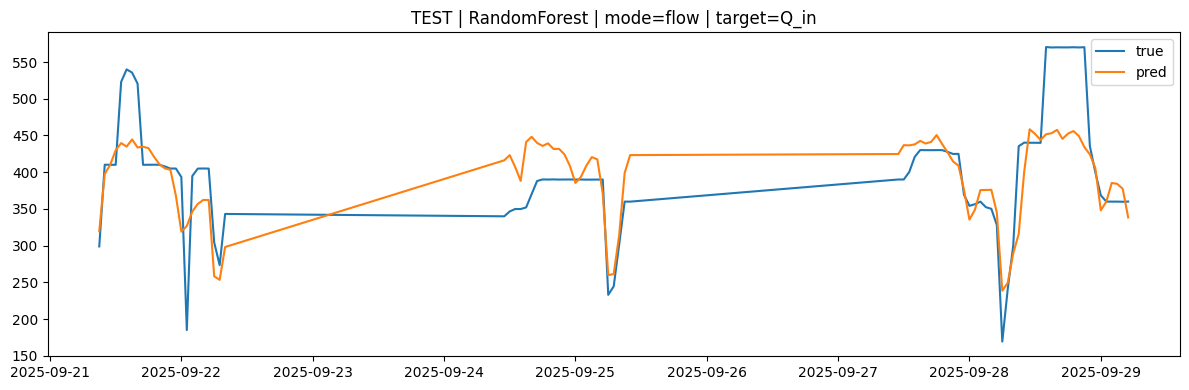

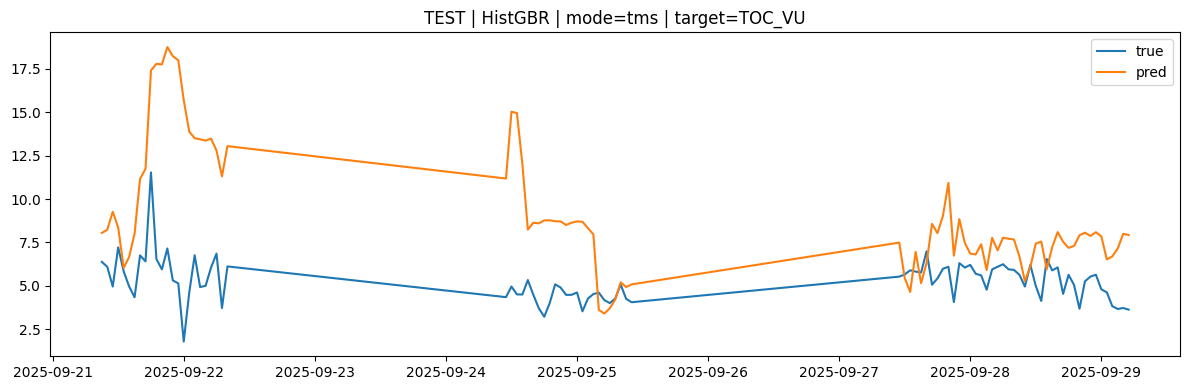

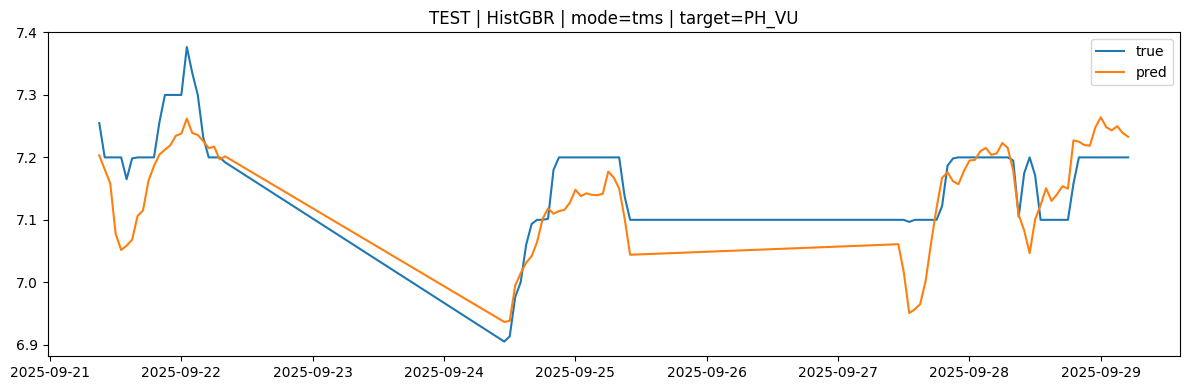

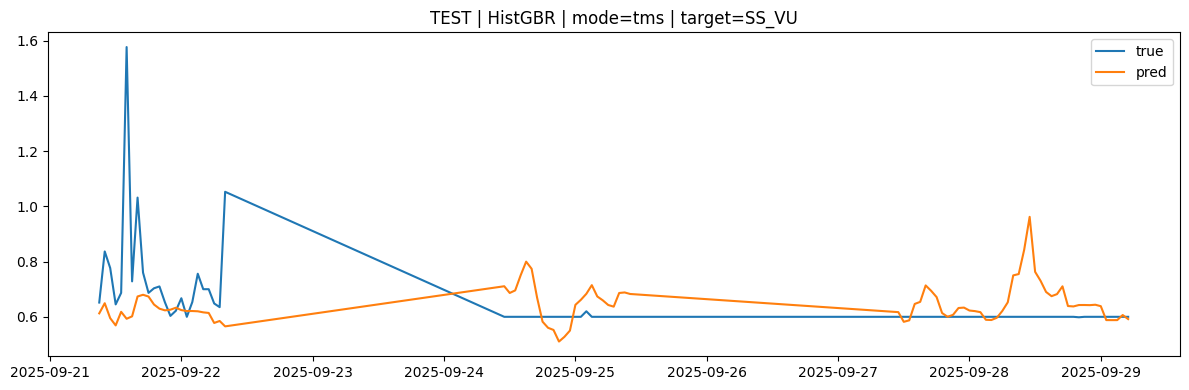

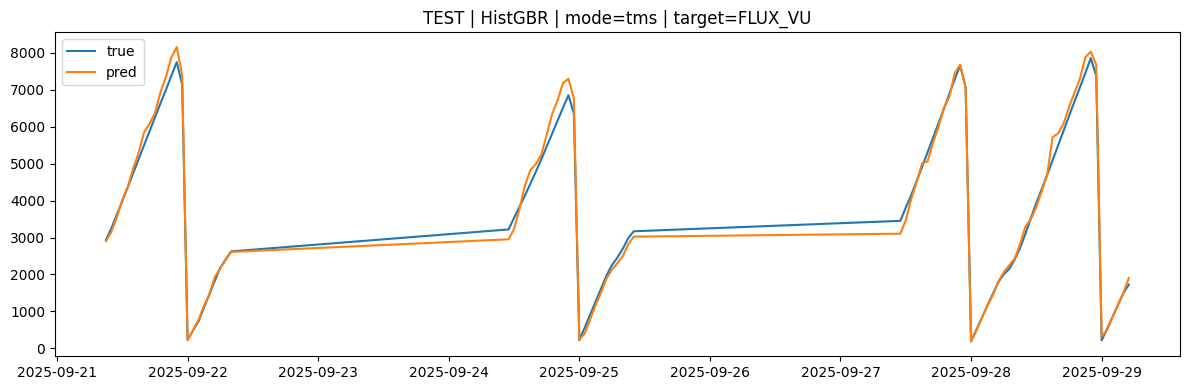

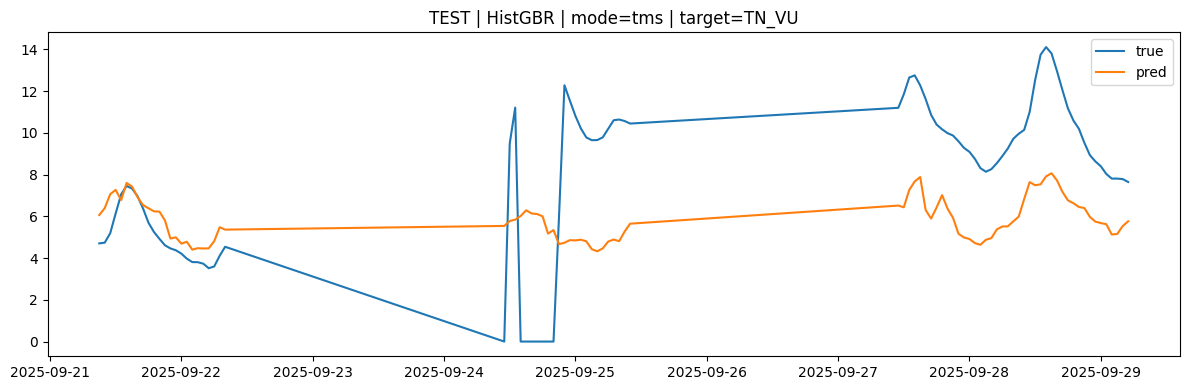

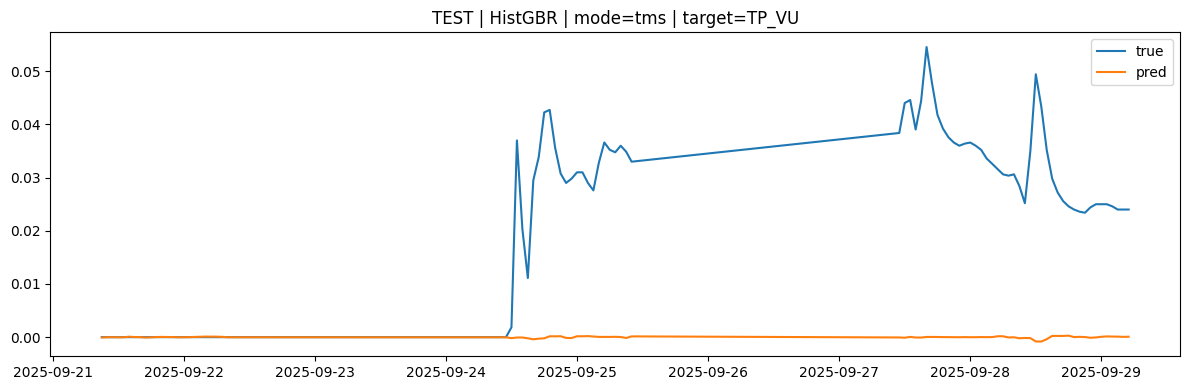

In [49]:
df_flow = pd.read_csv("../../../data/actual/FLOW_Actual.csv")
df_tms = pd.read_csv("../../../data/actual/TMS_Actual.csv")
df_aws_368 = pd.read_csv("../../../data/actual/AWS_368.csv")
df_aws_541 = pd.read_csv("../../../data/actual/AWS_541.csv")
df_aws_569 = pd.read_csv("../../../data/actual/AWS_569.csv")

for c in ["flow_TankA", "flow_TankB"]:
    df_flow[c] = pd.to_numeric(df_flow[c], errors="coerce")

df_flow["Q_in"] = df_flow["flow_TankA"] + df_flow["flow_TankB"]
df_flow = df_flow.drop(columns = ["flow_TankA", "flow_TankB"])

def prep_aws(df, suffix):
    out = df.copy()
    out["datetime"] = pd.to_datetime(out["datetime"], errors="coerce")  # 중요
    out = out.dropna(subset=["datetime"])
    out = out.set_index("datetime").sort_index()
    out = out.add_suffix(suffix)
    return out

aws368 = prep_aws(df_aws_368, "_368")
aws541 = prep_aws(df_aws_541, "_541")
aws569 = prep_aws(df_aws_569, "_569")

# 4) AWS inner join (공통 시간만)
df_aws = (
    aws368
    .merge(aws541, left_index=True, right_index=True, how="inner")
    .merge(aws569, left_index=True, right_index=True, how="inner")
)

df_aws["datetime"] = df_aws.index

dfs = {"flow": df_flow, "tms": df_tms, "aws": df_aws}

time_col_map = {"flow": "SYS_TIME", "tms": "SYS_TIME", "aws": "datetime"}

# (권장) 강수량 계열은 sum, 나머지는 mean: 컬럼명 패턴에 따라 자동 dict 만드는 방식도 가능
# resample_agg = "mean"
# 또는
# resample_agg = {col: ("sum" if col.startswith("RN") else "mean") for col in merged_columns}

out_flow = run_pipeline(dfs, mode="flow", time_col_map=time_col_map, tz=None, resample_agg="mean")
display(out_flow["period_summary"])
display(out_flow["metric_table"])

out_tms  = run_pipeline(dfs, mode="tms", time_col_map=time_col_map, tz=None, resample_agg="mean")
display(out_tms["metric_table"])

best_model_name = out_flow["metric_table"].iloc[0]["model"]
best_model = out_flow["fitted_models"][best_model_name]
X_test, y_test = out_flow["splits"]["test"]
y_pred = best_model.predict(X_test)
plot_predictions(y_test, y_pred, title=f"TEST | {best_model_name} | mode=flow", n_points=500)

best_model_name = out_tms["metric_table"].iloc[0]["model"]
best_model = out_tms["fitted_models"][best_model_name]
X_test, y_test = out_tms["splits"]["test"]
y_pred = best_model.predict(X_test)
plot_predictions(y_test, y_pred, title=f"TEST | {best_model_name} | mode=tms", n_points=500)